# 8 Easy Steps To Switch From Slow Pandas to Lightning Fast Polars
## A cheat sheet of the most common Pandas operations translated into Polars
![](images/midjourney.png)

### Time for goodbyes!

### 0. Reading/writing data

Even though it is painfully slow, CSV is still one of the most popular file formats to store data. So, let's start with the `read_csv` function of Polars.

Apart from the obvious speed benefits, it only differs from its Pandas namesake in terms of the number of parameters (Pandas `read_csv` has 49. Yep, I counted) and their syntax.

![](images/csv_io.png)

The confusing parameter names shouldn't be a problem as most modern IDEs have tab-completion or pop-up documentation features (__Shift + Tab__ on JupyterLab, thank you 🙏). 

If you were unaware, the `dtype` parameter prevents Pandas to set automatic datatypes and allows the user set custom ones like `string` type for `cut` or `datetime` for date-type columns.

You can use the same behavior in Polars with `dtypes` (mind the 's') thought it doesn't allow the types to be set via strings. You have to provide either Python built-in types or through Polars like `pl.Boolean`, `pl.Categorical`, `pl.DateTime`, `pl.Int64` or `pl.Null` for missing values. You can see the full list by calling `dir(pl)`.

Reading and writing Parquet files, which are much faster and more memory-efficient that CSVs, are also supported in Polars through `read_parquet` and `write_parquet` functions.

![](images/parquet_io.png)

### 1. Creating Series and DataFrames

![](images/create_series.png)

![](images/create_df.png)

### 2. Viewing data

- `head`, `tail` and `sample` are the same

![](images/describe.png)

### 3. What are expressions in Polars?

### 4. Selecting data

![](images/select.png)

```python
df.select(pl.exclude("price")).head()
```

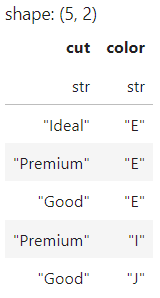

```python
df.select(pl.col("^c.+$")).head()
```

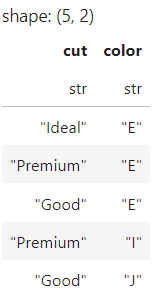

![](images/include_number.png)

### 5. Filtering data

![](images/is_between.png)

![](images/filter_ideal.png)

![](images/isin.png)

### 6. Creating new columns

![](images/new_col.png)

### 7. Groupby

![](images/groupby.png)

```python
df.groupby(
    "cut", maintain_order=True
).agg(pl.col("*").count())
```

![](images/agg.png)

### 8. The lazy API in Polars

### Conclusion